In [1]:
import os
import re
import imp
import sys

import numpy as np
import pandas as pd
import codecs
import nbimporter
import matplotlib.pyplot as plt
import seaborn as sns

import nltk
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('stopwords')

from collections import Counter
from DataProcessing import getfile, get_data, get_record
from HelperFunctions import wordcloud_draw
from gensim.corpora import Dictionary
from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import LogisticRegression

from TopicAnalysis import *
import DataProcessing
import HelperFunctions


from gensim.models.ldamulticore import LdaMulticore
from gensim.models.word2vec import Word2Vec

# hyperparameter training imports
from sklearn.model_selection import GridSearchCV

%matplotlib inline

[nltk_data] Downloading package punkt to /Users/sdalton/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /Users/sdalton/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/sdalton/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


# Data Loading and Preparation 

In [2]:
airport_codes = pd.read_csv('airport_codes.csv', header='infer', encoding='unicode-escape')

In [3]:
cities = airport_codes['city'].str.lower().tolist()
airport_code_list = airport_codes['airport_code'].tolist()

In [4]:
all_lines = []
getfile('./4U_Reviews.txt', all_lines)
len(all_lines)

1372

In [5]:
results = []
reviews_list = get_data(all_lines, results)
all_reviews = [get_record(review, cities) for review in reviews_list]

number of records: 127


In [6]:

data = pd.DataFrame(all_reviews)
data["review_year"] = data["review_date"].str[-4:].astype(int)
data["review_score"]= np.where(data["review_score"]=='na', -1, data["review_score"]).astype(int)
data["review_text_length"] = data["review_text"].str.count(' ').add(1)

data['possible_route2']=data['review_text'].str.findall("[A-Z]{3}-[A-Z]{3}-[A-Z]{3}|[A-Z]{3}-[A-Z]{3}").agg(lambda x: '-'.join(map(str, x))).astype('str')
data['route'] = np.where(data['Route'].fillna(data['possible_route'])=='',data['possible_route2'],data['Route'].fillna(data['possible_route']))
data['route'] = data['route'].str.replace('to','').str.replace('via', '').str.replace('-', ' ')
data['route_city1'] = data['route'].str.split(' ')
data['recommended'] = np.where(data.Recommended=='no', 0,1)
data['Type Of Traveller'] = data['Type Of Traveller'].fillna('Unknown')
data['review_text'] = data.review_text.str.lower()
data['review_text'] = data.review_text.str.replace('not be on time', 'delayed').str.replace('not on time', 'delayed').str.replace('on time', 'punctual').str.replace("'",'')

score_fields =['Cabin Staff Service','Food & Beverages', 'Ground Service', 'Inflight Entertainment',
       'Seat Comfort', 'Value For Money', 'Wifi & Connectivity']


for column in score_fields:
    new_name = 'scored_' + column.replace(' ', '').replace('&','')
    data[str(new_name)] = np.where(data[column]=='12345', 1, 0) 
    
data['total_scored_fields'] = data[[f for f in data.columns.values if 'scored_' in f]].sum(axis=1)    
data = data.drop(score_fields + ['Recommended','possible_route2', 'possible_route', 'Route'], axis=1)  

#I need to spend more time extracting route in order to identify if there are any specific routes that seem to be problematic

# Data Analysis

In [7]:
data.columns.values

array(['Aircraft', 'Cabin Flown', 'Date Flown', 'Type Of Traveller',
       'customer_name', 'review_country', 'review_date', 'review_score',
       'review_text', 'review_title', 'review_year', 'review_text_length',
       'route', 'route_city1', 'recommended', 'scored_CabinStaffService',
       'scored_FoodBeverages', 'scored_GroundService',
       'scored_InflightEntertainment', 'scored_SeatComfort',
       'scored_ValueForMoney', 'scored_WifiConnectivity',
       'total_scored_fields'], dtype=object)

                 mean  count
recommended                 
0            2.153846     65
1            7.806452     62


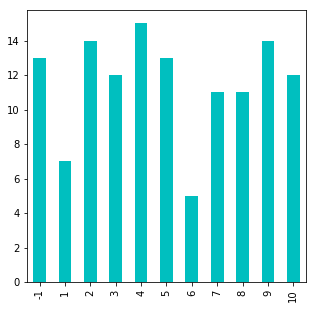

In [8]:
print(data.groupby('recommended')['review_score'].agg(['mean', 'count']))

data.review_score.value_counts().sort_index().plot.bar(color='c', figsize=(5, 5))

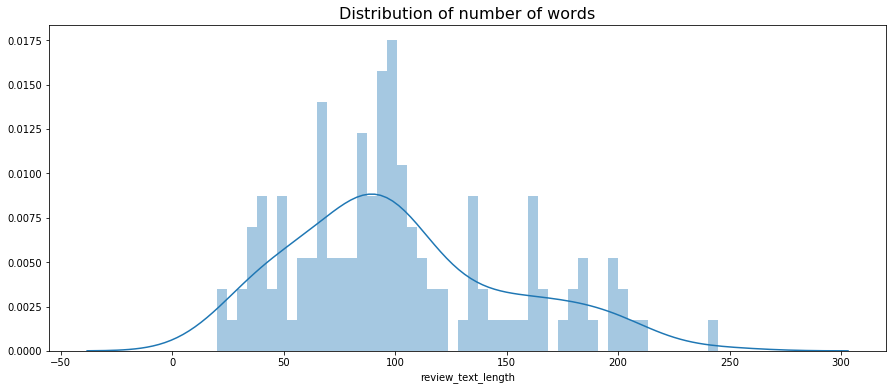

In [9]:
fig, ax = plt.subplots(figsize=(15,6))

ax.set_title("Distribution of number of words", fontsize=16)
ax.set_xlabel("Number of words")
sns.distplot(data['review_text_length'], bins=50, ax=ax);

In [10]:
data[data['review_score']==-1]['recommended'].agg(['mean', 'count'])  #all missing review scores are negative recommendations

mean      0.0
count    13.0
Name: recommended, dtype: float64

In [11]:
data[['recommended','review_score','review_text_length', 'total_scored_fields', 'review_year']].corr(method='pearson')

,recommended,review_score,review_text_length,total_scored_fields,review_year
recommended,1.000000,0.839095,-0.277349,0.036520,0.052490
review_score,0.839095,1.000000,-0.352571,0.072197,0.077828
review_text_length,-0.277349,-0.352571,1.000000,0.102338,0.111464
total_scored_fields,0.036520,0.072197,0.102338,1.000000,0.871991
review_year,0.052490,0.077828,0.111464,0.871991,1.000000


In [12]:
data[data.review_year > 2008][['recommended','review_score','review_text_length', 'total_scored_fields', 'review_year']].corr(method='pearson')

,recommended,review_score,review_text_length,total_scored_fields,review_year
recommended,1.000000,0.838627,-0.276680,-0.041826,-0.064947
review_score,0.838627,1.000000,-0.359237,0.022760,0.005057
review_text_length,-0.276680,-0.359237,1.000000,0.126633,0.155261
total_scored_fields,-0.041826,0.022760,0.126633,1.000000,0.859991
review_year,-0.064947,0.005057,0.155261,0.859991,1.000000


In [13]:
#13 records are missing review score --filled with -1
data[data["review_score"]>0].groupby(['review_year']).agg(['mean', 'count'])
data[data["review_score"]>0].groupby(['Type Of Traveller']).agg(['mean', 'count'])

review_score       review_year       review_text_length  \
                          mean count        mean count               mean   
Type Of Traveller                                                           
Business                  3.80     5     2015.00     5              85.80   
Couple Leisure            2.60     5     2015.00     5             149.20   
FamilyLeisure             6.00     2     2015.00     2             115.00   
Solo Leisure              5.00     2     2015.00     2              75.00   
Unknown                   5.83   100     2012.21   100              95.58   

                        recommended       scored_CabinStaffService        \
                  count        mean count                     mean count   
Type Of Traveller                                                          
Business              5        0.20     5                     1.00     5   
Couple Leisure        5        0.00     5                     1.00     5   
FamilyLeisure         2        0.50     2                     1.00     2   
Solo Leisure          2        0.50     2                     1.00     2   
Unknown             100        0.59   100                     0.58   100   

                   ...  scored_InflightEntertainment       scored_SeatComfort  \
                   ...                          mean count               mean   
Type Of Traveller  ...                                                          
Business           ...                          0.40     5               1.00   
Couple Leisure     ...                          0.20     5               1.00   
FamilyLeisure      ...                          0.50     2               1.00   
Solo Leisure       ...                          0.50     2               1.00   
Unknown            ...                          0.26   100               0.58   

                        scored_ValueForMoney       scored_WifiConnectivity  \
                  count                 mean count                    mean   
Type Of Traveller                                                            
Business              5                 1.00     5                     0.2   
Couple Leisure        5                 1.00     5                     0.2   
FamilyLeisure         2                 1.00     2                     0.5   
Solo Leisure          2                 1.00     2                     0.5   
Unknown             100                 0.88   100                     0.0   

                        total_scored_fields        
                  count                mean count  
Type Of Traveller                                  
Business              5                5.60     5  
Couple Leisure        5                5.00     5  
FamilyLeisure         2                6.00     2  
Solo Leisure          2                5.50     2  
Unknown             100                2.76   100  

[5 rows x 24 columns]

In [14]:
data[data["review_score"]>0].groupby(['Type Of Traveller']).agg(['mean', 'count'])

review_score       review_year       review_text_length  \
                          mean count        mean count               mean   
Type Of Traveller                                                           
Business                  3.80     5     2015.00     5              85.80   
Couple Leisure            2.60     5     2015.00     5             149.20   
FamilyLeisure             6.00     2     2015.00     2             115.00   
Solo Leisure              5.00     2     2015.00     2              75.00   
Unknown                   5.83   100     2012.21   100              95.58   

                        recommended       scored_CabinStaffService        \
                  count        mean count                     mean count   
Type Of Traveller                                                          
Business              5        0.20     5                     1.00     5   
Couple Leisure        5        0.00     5                     1.00     5   
FamilyLeisure         2        0.50     2                     1.00     2   
Solo Leisure          2        0.50     2                     1.00     2   
Unknown             100        0.59   100                     0.58   100   

                   ...  scored_InflightEntertainment       scored_SeatComfort  \
                   ...                          mean count               mean   
Type Of Traveller  ...                                                          
Business           ...                          0.40     5               1.00   
Couple Leisure     ...                          0.20     5               1.00   
FamilyLeisure      ...                          0.50     2               1.00   
Solo Leisure       ...                          0.50     2               1.00   
Unknown            ...                          0.26   100               0.58   

                        scored_ValueForMoney       scored_WifiConnectivity  \
                  count                 mean count                    mean   
Type Of Traveller                                                            
Business              5                 1.00     5                     0.2   
Couple Leisure        5                 1.00     5                     0.2   
FamilyLeisure         2                 1.00     2                     0.5   
Solo Leisure          2                 1.00     2                     0.5   
Unknown             100                 0.88   100                     0.0   

                        total_scored_fields        
                  count                mean count  
Type Of Traveller                                  
Business              5                5.60     5  
Couple Leisure        5                5.00     5  
FamilyLeisure         2                6.00     2  
Solo Leisure          2                5.50     2  
Unknown             100                2.76   100  

[5 rows x 24 columns]

# Sentiment Analysis on Text Review

In [15]:
all_reviews = data['review_text']
all_sent_values = []
all_sentiments = []

In [16]:
# Functions for Sentiment Analysis to be moved to an external file later

from nltk.sentiment.vader import SentimentIntensityAnalyzer
nltk.download('vader_lexicon')
def sentiment_value(paragraph):
    analyser = SentimentIntensityAnalyzer()
    result = analyser.polarity_scores(paragraph)
    score = result['compound']
    return round(score,1)

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /Users/sdalton/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


/Users/sdalton/anaconda3/lib/python3.6/site-packages/nltk/twitter/__init__.py:20: UserWarning: The twython library has not been installed. Some functionality from the twitter package will not be available.
  warnings.warn("The twython library has not been installed. "


In [17]:
sample = data['review_text'][12]
print(sample)
print('Sentiment: ' + 'Recommended: ' + str(data['recommended'][12]) + 'Review Score: ' + str(data['review_score'][12])  )
print(sentiment_value(sample))

the flight was delayed by 6 hours, allegedly because of a radar system failure at rome fiumicino airport. strangely, only the germanwings flight to berlin was affected, air berlin left punctual. delays can happen, but the complete lack of information and assistance was not acceptable. no ground staff was available, phone calls to germanwings were not answered. no meal voucher was offered. to add insult to injury, access to star alliance lounges is denied to gold members outside germany when you travel with germanwings because they are a lufthansa subsidiary but not a member of star alliance. the flight itself was smooth, but no inflight entertainment whatsoever. for the same price, air berlin offers much better value. will not travel germanwings again.
Sentiment: Recommended: 0Review Score: 1
-0.6


recommended
0   -0.147692
1    0.619355
Name: text_sentiment_score, dtype: float64


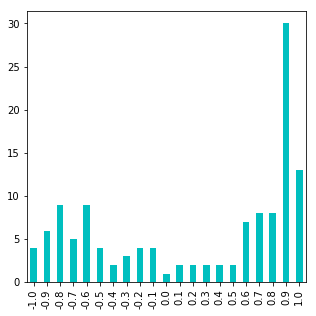

In [18]:
data['text_sentiment_score'] = data['review_text'].apply(lambda x: sentiment_value(x))
#sanity check on recommended yes/no vs sentiment of text
print(data.groupby('recommended')['text_sentiment_score'].mean())
data.text_sentiment_score.value_counts().sort_index().plot.bar(color='c', figsize=(5, 5))
#looks odd there are not many neutral reviews and quite a few positive texts

In [19]:
#text sentiment score and review score are highly correlated, but review score is more higly correlated with recommended that text sentiment score
print(data[['text_sentiment_score', 'recommended', 'review_score']].corr())
print(data[data.review_score == -1][['text_sentiment_score', 'recommended']].mean()) 
data[data.review_score > -1][['text_sentiment_score', 'recommended', 'review_score']].corr()

                      text_sentiment_score  recommended  review_score
text_sentiment_score              1.000000     0.533772      0.640631
recommended                       0.533772     1.000000      0.839095
review_score                      0.640631     0.839095      1.000000
text_sentiment_score   -0.569231
recommended             0.000000
dtype: float64


,text_sentiment_score,recommended,review_score
text_sentiment_score,1.000000,0.481404,0.575925
recommended,0.481404,1.000000,0.846576
review_score,0.575925,0.846576,1.000000


# Topic Modelling Support Functions (to be removed to external file pending fix)

In [20]:
#This should be added to a separate Package BUT it's currently not working, so I will come back to it later (it's not finding nltk when loaded)

def get_good_tokens(sentence):
    replaced_punctation = list(map(lambda token: re.sub('[^0-9A-Za-z!?]+', '', token), sentence))
    removed_punctation = list(filter(lambda token: token, replaced_punctation))
    return removed_punctation

def w2v_preprocessing(df):
    """ All the preprocessing steps for word2vec are done in this function.
    All mutations are done on the dataframe itself. So this function returns
    nothing.
    """
    
    df['document_sentences'] = df.review_text.str.split('.')  # split texts into individual sentences
    df['tokenized_sentences'] = list(map(lambda sentences:
                                         list(map(nltk.word_tokenize, sentences)),
                                         df.document_sentences))  # tokenize sentences
    df['tokenized_sentences'] = list(map(lambda sentences:
                                         list(map(get_good_tokens, sentences)),
                                         df.tokenized_sentences))  # remove unwanted characters
    df['tokenized_sentences'] = list(map(lambda sentences:
                                         list(filter(lambda lst: lst, sentences)),
                                         df.tokenized_sentences))  # remove empty list
    

def lda_get_good_tokens(df):
    df['tokenized_text'] = list(map(nltk.word_tokenize, df.review_text))
    df['tokenized_text'] = list(map(get_good_tokens, df.tokenized_text))
    
def word_frequency_barplot(df, nr_top_words=50):
    """ df should have a column named count.
    """
    fig, ax = plt.subplots(1,1,figsize=(20,5))

    sns.barplot(list(range(nr_top_words)), df['count'].values[:nr_top_words], palette='hls', ax=ax)

    ax.set_xticks(list(range(nr_top_words)))
    ax.set_xticklabels(df.index[:nr_top_words], fontsize=14, rotation=90)
    return ax
    
    
def remove_stopwords(df, stopWords, dropList):
    """ Removes stopwords based on a known set of stopwords
    available in the nltk package. In addition, we include our
    made up word in here.
    """
    # Luckily nltk already has a set of stopwords that we can remove from the texts.
    stopwords = stopWords + dropList
    # we'll add our own special word in here 'qwerty'
    #stopwords.append(dropList)

    df['stopwords_removed'] = list(map(lambda doc:
                                       [word for word in doc if word not in stopwords],
                                       df['tokenized_text']))

def stem_words(df):
    lemm = nltk.stem.WordNetLemmatizer()
    df['lemmatized_text'] = list(map(lambda sentence:
                                     list(map(lemm.lemmatize, sentence)),
                                     df.stopwords_removed))

    p_stemmer = nltk.stem.porter.PorterStemmer()
    df['stemmed_text'] = list(map(lambda sentence:
                                  list(map(p_stemmer.stem, sentence)),
                                  df.lemmatized_text))
     
        
def document_to_bow(df):
    df['bow'] = list(map(lambda doc: dictionary.doc2bow(doc), df.stemmed_text))
    
    
def lda_preprocessing(df):
    """ All the preprocessing steps for LDA are combined in this function.
    All mutations are done on the dataframe itself. So this function returns
    nothing.
    """
    lda_get_good_tokens(df)
    remove_stopwords(df)
    stem_words(df)
    document_to_bow(df)    
    
def document_to_lda_features(lda_model, document):
    """ Transforms a bag of words document to features.
    It returns the proportion of how much each topic was
    present in the document.
    """
    topic_importances = LDAmodel.get_document_topics(document, minimum_probability=0)
    topic_importances = np.array(topic_importances)
    return topic_importances[:,1]    
    
def get_topic_top_words(lda_model, topic_id, nr_top_words=5):
    """ Returns the top words for topic_id from lda_model.
    """
    id_tuples = lda_model.get_topic_terms(topic_id, topn=nr_top_words)
    word_ids = np.array(id_tuples)[:,0]
    words = map(lambda id_: lda_model.id2word[id_], word_ids)
    return words

def get_w2v_features(w2v_model, sentence_group):
    """ Transform a sentence_group (containing multiple lists
    of words) into a feature vector. It averages out all the
    word vectors of the sentence_group.
    """
    words = np.concatenate(sentence_group)  # words in text
    index2word_set = set(w2v_model.wv.vocab.keys())  # words known to model
    
    featureVec = np.zeros(w2v_model.vector_size, dtype="float32")
    
    # Initialize a counter for number of words in a review
    nwords = 0
    # Loop over each word in the comment and, if it is in the model's vocabulary, add its feature vector to the total
    for word in words:
        if word in index2word_set: 
            featureVec = np.add(featureVec, w2v_model[word])
            nwords += 1.

    # Divide the result by the number of words to get the average
    if nwords > 0:
        featureVec = np.divide(featureVec, nwords)
    return featureVec



# Topic Modelling-- Actual work

I want to identify the the topics that determine whether a customer would recommend yes or no to Germanwings (and which topics appear most often as a source of complaint/praise/value for the customer.  Also can these reviews be used to determine whether a customer will recommend Germanwings, perhaps promotions or other sources of customer intervention can be used to encourage disatisfied customers or borderline happy customers to fly with Germanwings again.

--Note I need to optimize better, currently I don't have a hold out set to test topic analysis and 

In [21]:
from gensim.models import Word2Vec
from gensim.models.phrases import Phraser, Phrases
import gensim
from gensim.utils import simple_preprocess
from gensim.parsing.preprocessing import STOPWORDS    
import nltk

# keepList=['no', 'not','don','again','very', 'only', 'so', 'really', 'don', 'does', \
#           'doesn', 'against', 'all', 'always', 'cant', 'cannot', 'cry', 'less', 'more', 'most', 'least', 'much']
drop = ['germanwings', 'flight', 'flights', 'passengers', 'passenger', 'lufthansa', 'airline']
gensim_stopwords = list(gensim.parsing.preprocessing.STOPWORDS)
nltk_stopwords = [item.replace("'",'') for item in nltk.corpus.stopwords.words('english')  ] 
    

In [22]:
w2v_preprocessing(data)     
lda_get_good_tokens(data)
remove_stopwords(data, gensim_stopwords, drop)
stem_words(data)

In [23]:

tokenized_only_dict = Counter(np.concatenate(data.stopwords_removed.values))
tokenized_only_df = pd.DataFrame.from_dict(tokenized_only_dict, orient='index')
tokenized_only_df.rename(columns={0: 'count'}, inplace=True)
tokenized_only_df.sort_values('count', ascending=False, inplace=True)

In [24]:
tokenized_only_df[tokenized_only_df['count'] >1][0:50]

,count
service,52
good,51
crew,49
return,47
staff,42
cologne,42
time,42
seats,40
late,37
seat,37


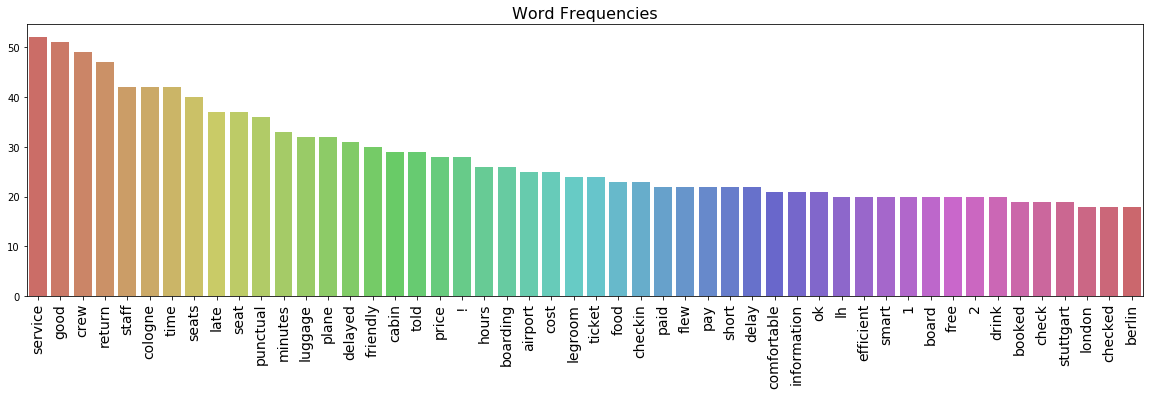

In [25]:
ax = word_frequency_barplot(tokenized_only_df)
ax.set_title("Word Frequencies", fontsize=16);
    

In [26]:
dictionary = Dictionary(documents=data.stemmed_text.values)

print("Found {} words.".format(len(dictionary.values())))

dictionary.filter_extremes(no_above=0.95, no_below=2)

dictionary.compactify()  # Reindexes the remaining words after filtering
print("Left with {} words.".format(len(dictionary.values())))

document_to_bow(data)

cleansed_words_df = pd.DataFrame.from_dict(dictionary.token2id, orient='index')
cleansed_words_df.rename(columns={0: 'id'}, inplace=True)

cleansed_words_df['count'] = list(map(lambda id_: dictionary.dfs.get(id_), cleansed_words_df.id))
del cleansed_words_df['id']

Found 1609 words.
Left with 704 words.


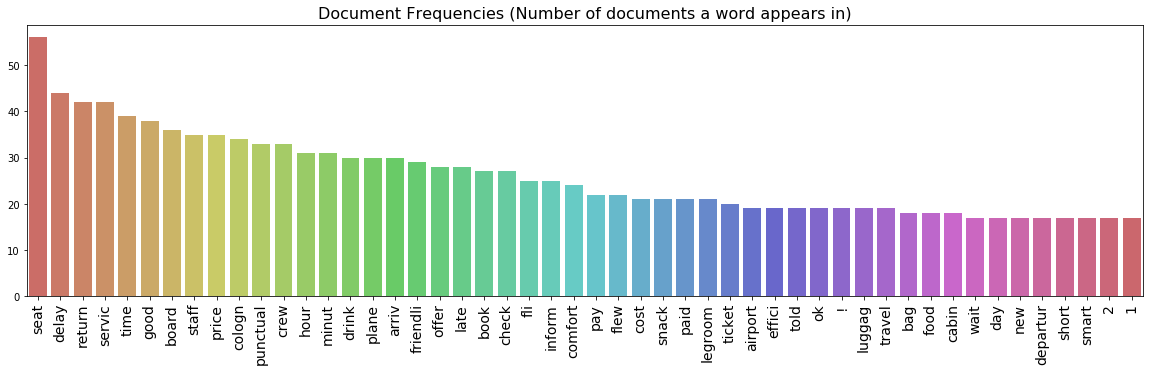

In [27]:
cleansed_words_df.sort_values('count', ascending=False, inplace=True)

ax = word_frequency_barplot(cleansed_words_df)
ax.set_title("Document Frequencies (Number of documents a word appears in)", fontsize=16);


In [28]:
no_words = list(np.concatenate(data.loc[data.recommended == 0, 'stemmed_text'].values))
yes_words = list(np.concatenate(data.loc[data.recommended == 1, 'stemmed_text'].values))

no_word_frequencies = {word: no_words.count(word) for word in cleansed_words_df.index[:50]}
yes_word_frequencies = {word: yes_words.count(word) for word in cleansed_words_df.index[:50]}

frequencies_df = pd.DataFrame(index=cleansed_words_df.index[:50])
frequencies_df['no_freq'] = list(map(lambda word:
                                      no_word_frequencies[word],
                                      frequencies_df.index))
frequencies_df['yes_freq'] = list(map(lambda word:
                                          yes_word_frequencies[word],
                                          frequencies_df.index))

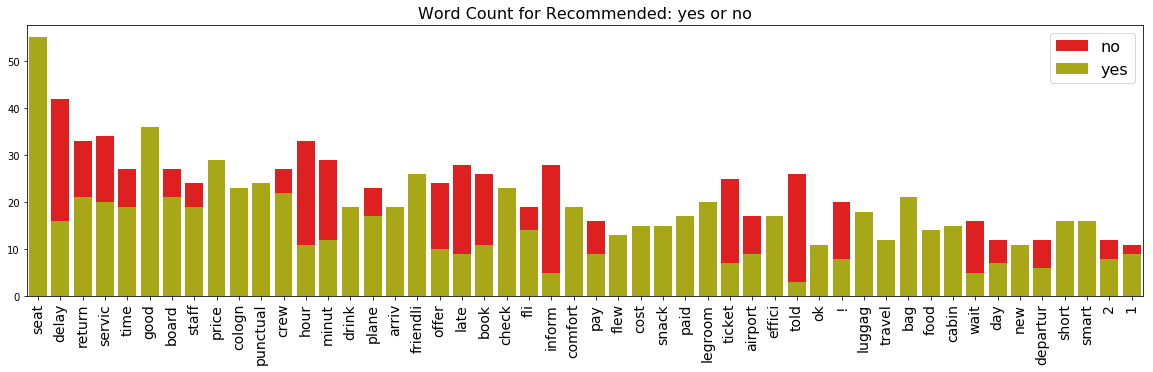

In [29]:
fig, ax = plt.subplots(1,1,figsize=(20,5))

nr_top_words = len(frequencies_df)
nrs = list(range(nr_top_words))
sns.barplot(nrs, frequencies_df['no_freq'].values, color='r', ax=ax, label="no")
sns.barplot(nrs, frequencies_df['yes_freq'].values, color='y', ax=ax, label="yes")

ax.set_title("Word Count for Recommended: yes or no", fontsize=16)
ax.legend(prop={'size': 16})
ax.set_xticks(nrs)
ax.set_xticklabels(frequencies_df.index, fontsize=14, rotation=90);


It looks as though people don't like to be told or informed or delayed or waiting (and perhaps they are emphatic about that!)!!  People that wouldn't recommend Germanwings also seem to have issues with tickets and bookings and some service.  Customers that recommend Germanwings seam ok with the seat, the price, punctuality, crew/staff cabin and baggage. This coukd be misleading though if there are any negatives in front of these topics. 

## LDA

LDA  should give us some idea about the topics that appear in both positive and negative reviews

In [30]:

corpus = data.bow

num_topics = 20
#A multicore approach to decrease training time
LDAmodel = LdaMulticore(corpus=corpus,
                        id2word=dictionary,
                        num_topics=num_topics,
                        workers=4,
                        chunksize=4000,
                        passes=7,
                        alpha='asymmetric')

In [31]:


data['lda_features'] = list(map(lambda doc:
                                      document_to_lda_features(LDAmodel, doc),
                                      data.bow))

In [32]:
no_topic_distribution = data.loc[data.recommended == 0, 'lda_features'].mean()
yes_topic_distribution = data.loc[data.recommended == 1, 'lda_features'].mean()


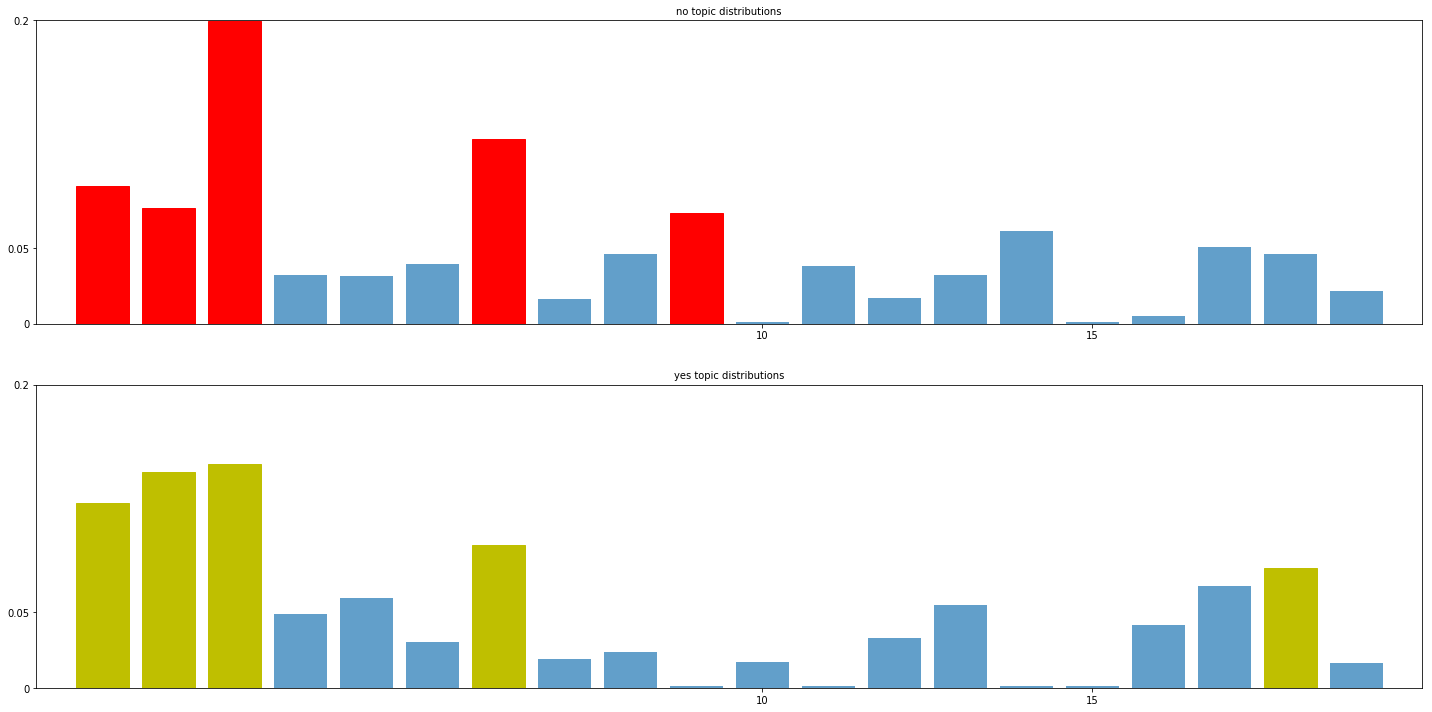

In [33]:
fig, [ax1,ax2] = plt.subplots(2,1,figsize=(20,10))

nr_top_bars = 5

ax1.set_title("no topic distributions", fontsize=10)
ax2.set_title("yes topic distributions", fontsize=10)
# ax1.text(-10, 0.4, "Average Probability of Topic", fontsize=30, ha="center", va="center",
#          rotation="vertical")

for ax, distribution, color in zip([ax1,ax2],
                                   [no_topic_distribution,yes_topic_distribution],
                                   ['r','y']):
    # Individual distribution barplots
    ax.bar(range(len(distribution)), distribution, alpha=0.7)
    rects = ax.patches
    for i in np.argsort(distribution)[-nr_top_bars:]:
        rects[i].set_color(color)
        rects[i].set_alpha(1)
    # General plotting adjustments
    ax.set_xlim(-1, num_topics)
    ax.set_xticks(range(10,num_topics,5))
    ax.set_xticklabels(range(10,num_topics,5), fontsize=10)
    ax.set_ylim(0,0.2)
    ax.set_yticks([0,0.2,0.05])
    ax.set_yticklabels([0,0.2,0.05], fontsize=10)

fig.tight_layout(h_pad=3.)

In [34]:
for recommended, distribution in zip(['no', 'yes'], [no_topic_distribution, yes_topic_distribution]):
    print("Looking up top words from top topics from {}.".format(recommended))
    for x in sorted(np.argsort(distribution)[-8:]):
        top_words = get_topic_top_words(LDAmodel, x)
        print("For topic {}, the top words are: {}.".format(x, ", ".join(top_words)))
    print("")

Looking up top words from top topics from no.
For topic 0, the top words are: staff, good, seat, crew, time.
For topic 1, the top words are: seat, check, good, luggag, smart.
For topic 2, the top words are: servic, cost, seat, delay, price.
For topic 6, the top words are: time, return, late, board, cologn.
For topic 8, the top words are: use, oper, chang, call, london.
For topic 9, the top words are: berlin, hour, book, time, later.
For topic 14, the top words are: servic, custom, return, staff, option.
For topic 17, the top words are: inform, offer, crew, cabin, delay.

Looking up top words from top topics from yes.
For topic 0, the top words are: staff, good, seat, crew, time.
For topic 1, the top words are: seat, check, good, luggag, smart.
For topic 2, the top words are: servic, cost, seat, delay, price.
For topic 4, the top words are: seat, minut, plane, bu, outbound.
For topic 6, the top words are: time, return, late, board, cologn.
For topic 13, the top words are: seat, ticket, 

In [35]:
#word2vec

sentences = []
for sentence_group in data.tokenized_sentences:
    sentences.extend(sentence_group)

print("Number of sentences: {}.".format(len(sentences)))
print("Number of texts: {}.".format(len(data)))


Number of sentences: 900.
Number of texts: 127.


In [36]:
# Set values for various parameters
num_features = 100    # Word vector dimensionality
min_word_count = 2    # Minimum word count
num_workers = 4       # Number of threads to run in parallel
context = 6           # Context window size
downsampling = 1e-3   # Downsample setting for frequent words

# Initialize and train the model
W2Vmodel = Word2Vec(sentences=sentences,
                    sg=1,
                    hs=0,
                    workers=num_workers,
                    size=num_features,
                    min_count=min_word_count,
                    window=context,
                    sample=downsampling,
                    negative=5,
                    iter=6)

In [37]:

data['w2v_features'] = list(map(lambda sen_group:
                                      get_w2v_features(W2Vmodel, sen_group),
                                      data.tokenized_sentences))

/Users/sdalton/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:114: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).


In [38]:
no_w2v_distribution = data.loc[data.recommended == 0, 'w2v_features'].mean()
yes_w2v_distribution = data.loc[data.recommended == 1, 'w2v_features'].mean()


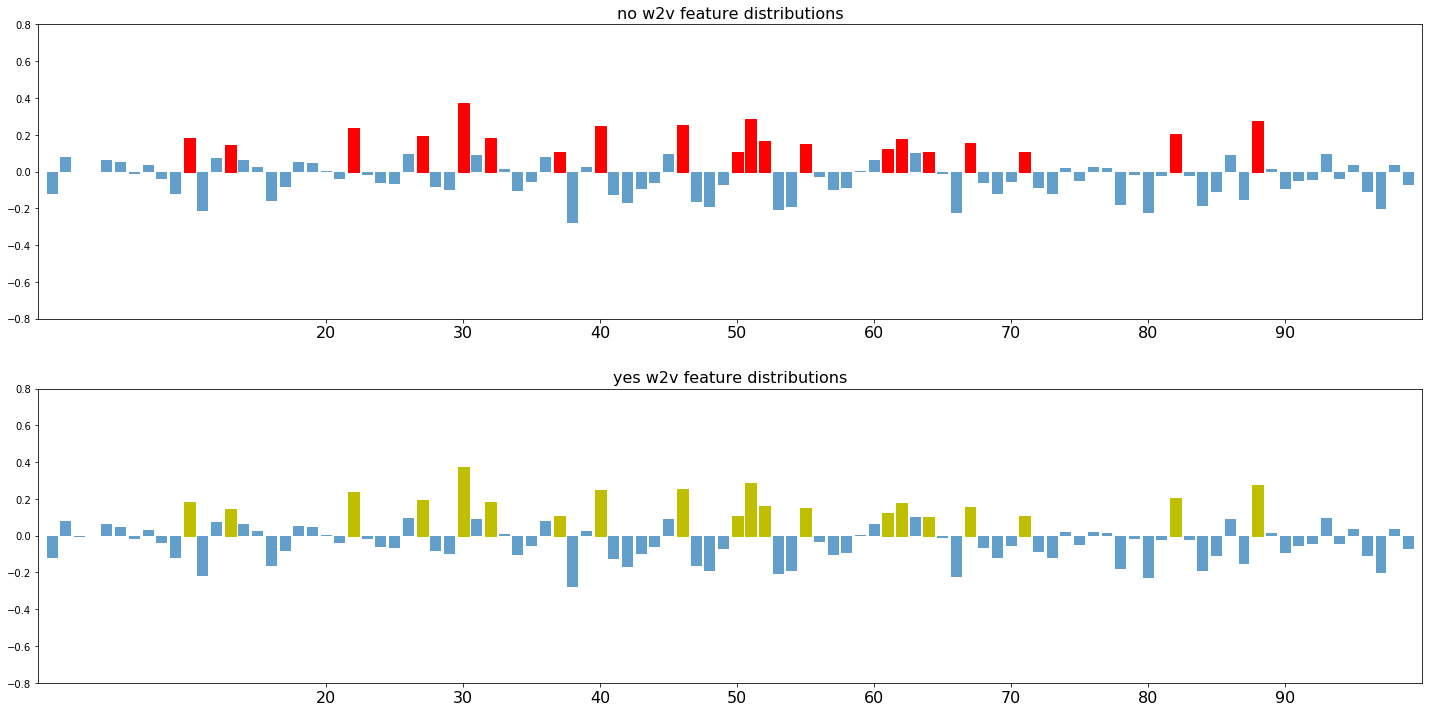

In [39]:
fig, [ax1,ax2] = plt.subplots(2,1,figsize=(20,10))

nr_top_bars = 20

ax1.set_title("no w2v feature distributions", fontsize=16)
ax2.set_title("yes w2v feature distributions", fontsize=16)
#ax1.text(-10, 2.3, "Average feature vectors", fontsize=30, ha="center", va="center", rotation="vertical")

for ax, distribution, color in zip([ax1,ax2], [no_w2v_distribution,yes_w2v_distribution], ['r','y']):
    # Individual distribution barplots
    ax.bar(range(len(distribution)), distribution, alpha=0.7)
    rects = ax.patches
    for i in np.argsort(distribution)[-nr_top_bars:]:
        rects[i].set_color(color)
        rects[i].set_alpha(1)
    # General plotting adjustments
    ax.set_xlim(-1, 100)
    ax.set_xticks(range(20,100,10))
    ax.set_xticklabels(range(20,100,10), fontsize=16)
    ax.set_ylim(-0.8,0.8)

fig.tight_layout(h_pad=3.)


####this plot looks suspicious, I need to investigate

In [40]:
label_encoder = LabelEncoder()

label_encoder.fit(data.recommended)
data['recommended'] = label_encoder.transform(data.recommended)

In [41]:
def get_cross_validated_model(model, param_grid, X, y, nr_folds=5):
    """ Trains a model by doing a grid search combined with cross validation.
    args:
        model: your model
        param_grid: dict of parameter values for the grid search
    returns:
        Model trained on entire dataset with hyperparameters chosen from best results in the grid search.
    """
    # train the model (since the evaluation is based on the logloss, we'll use neg_log_loss here)
    grid_cv = GridSearchCV(model, param_grid=param_grid, scoring='neg_log_loss', cv=nr_folds, n_jobs=-1, verbose=True)
    best_model = grid_cv.fit(X, y)
    # show top models with parameter values
    result_df = pd.DataFrame(best_model.cv_results_)
    show_columns = ['mean_test_score', 'mean_train_score', 'rank_test_score']
    for col in result_df.columns:
        if col.startswith('param_'):
            show_columns.append(col)
    display(result_df[show_columns].sort_values(by='rank_test_score').head())
    return best_model

In [42]:
X_train_lda = np.array(list(map(np.array, data.lda_features)))
X_train_w2v = np.array(list(map(np.array, data.w2v_features)))
X_train_combined = np.append(X_train_lda, X_train_w2v, axis=1)


In [43]:
models = dict()

# LDA features only
lr = LogisticRegression()

param_grid = {'penalty': ['l1', 'l2']}

best_lr_lda = get_cross_validated_model(lr, param_grid, X_train_lda, data.recommended, 3)

models['best_lr_lda'] = best_lr_lda

# Word2Vec features only
lr = LogisticRegression()

param_grid = {'penalty': ['l1', 'l2']}

best_lr_w2v = get_cross_validated_model(lr, param_grid, X_train_w2v, data.recommended, 3)

models['best_lr_w2v'] = best_lr_w2v



Fitting 3 folds for each of 2 candidates, totalling 6 fits


[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished
/Users/sdalton/anaconda3/lib/python3.6/site-packages/sklearn/utils/deprecation.py:122: FutureWarning: You are accessing a training score ('mean_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
/Users/sdalton/anaconda3/lib/python3.6/site-packages/sklearn/utils/deprecation.py:122: FutureWarning: You are accessing a training score ('split0_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
/Users/sdalton/anaconda3/lib/python3.6/site-packages/sklearn/utils/deprecation.py:122: FutureWarning: You are accessing a training score ('split1_train_score'), which will not be available by default 

,mean_test_score,mean_train_score,rank_test_score,param_penalty
1,-0.672349,-0.631125,1,l2
0,-0.679498,-0.664640,2,l1


Fitting 3 folds for each of 2 candidates, totalling 6 fits


[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.1s finished
/Users/sdalton/anaconda3/lib/python3.6/site-packages/sklearn/utils/deprecation.py:122: FutureWarning: You are accessing a training score ('mean_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
/Users/sdalton/anaconda3/lib/python3.6/site-packages/sklearn/utils/deprecation.py:122: FutureWarning: You are accessing a training score ('split0_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
/Users/sdalton/anaconda3/lib/python3.6/site-packages/sklearn/utils/deprecation.py:122: FutureWarning: You are accessing a training score ('split1_train_score'), which will not be available by default 

,mean_test_score,mean_train_score,rank_test_score,param_penalty
1,-0.692841,-0.692828,1,l2
0,-0.693147,-0.693147,2,l1


In [44]:
for name, model in models.items():
    print("Model {} has a test score of: {:0.4f}".format(name, float(model.best_score_)))


Model best_lr_lda has a test score of: -0.6723
Model best_lr_w2v has a test score of: -0.6928


In [45]:
#Word Cloud

Positive words


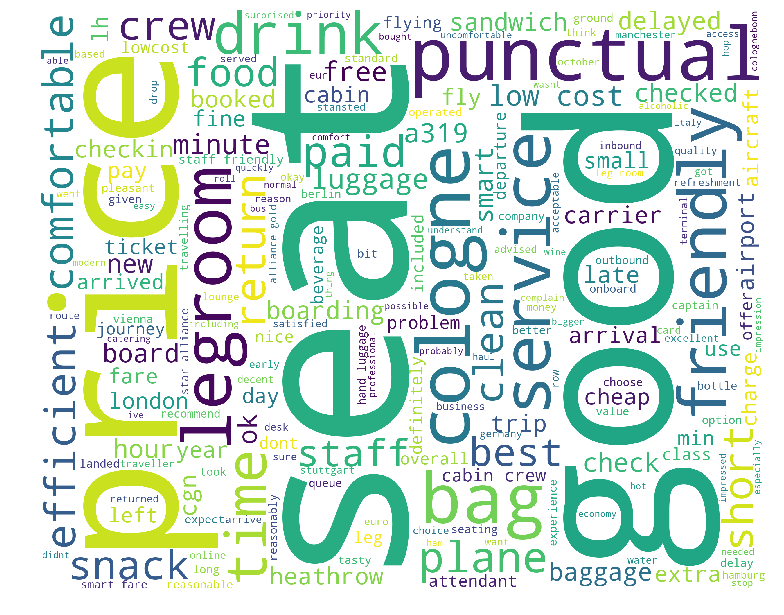

In [46]:
print("Positive words")
wordcloud_draw(data[data["recommended"]==1]['stopwords_removed'].agg(lambda x: ' '.join(map(str, x))).astype('str'),'white')

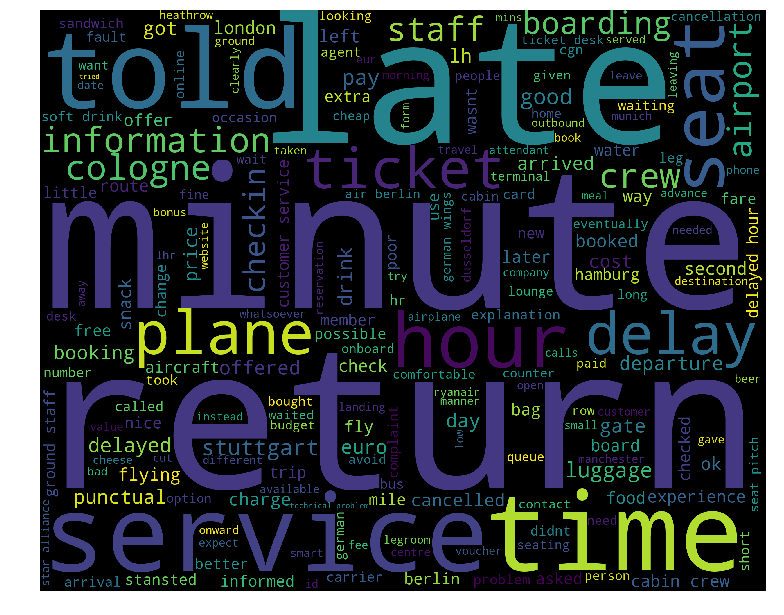

In [47]:
wordcloud_draw(data[data["recommended"]==0]['stopwords_removed'].agg(lambda x: ' '.join(map(str, x))).astype('str'))